### Train Gene classifier 
Because arounf 1/4 of the Gene column are missing, training a classifier to predict the Gene column could help with regression and classificaion task on the target fields

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Install xlrd package
%pip install xlrd

df = pd.read_excel('TrainDataset2024.xls', index_col=False)
df.drop('ID', axis=1, inplace=True)
df.head()


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,1,144.0,41.0,0,0,0,1,3,3,1,...,0.517172,0.375126,3.325332,0.002314,3880771.500,473.464852,0.000768,0.182615,0.030508,0.000758
1,0,142.0,39.0,1,1,0,0,3,3,1,...,0.444391,0.444391,3.032144,0.005612,2372009.744,59.459710,0.004383,0.032012,0.001006,0.003685
2,1,135.0,31.0,0,0,0,1,2,1,1,...,0.534549,0.534549,2.485848,0.006752,1540027.421,33.935384,0.007584,0.024062,0.000529,0.006447
3,0,12.0,35.0,0,0,0,1,3,3,1,...,0.506185,0.506185,2.606255,0.003755,6936740.794,46.859265,0.005424,0.013707,0.000178,0.004543
4,0,109.0,61.0,1,0,0,0,2,1,1,...,0.462282,0.462282,2.809279,0.006521,1265399.054,39.621023,0.006585,0.034148,0.001083,0.005626


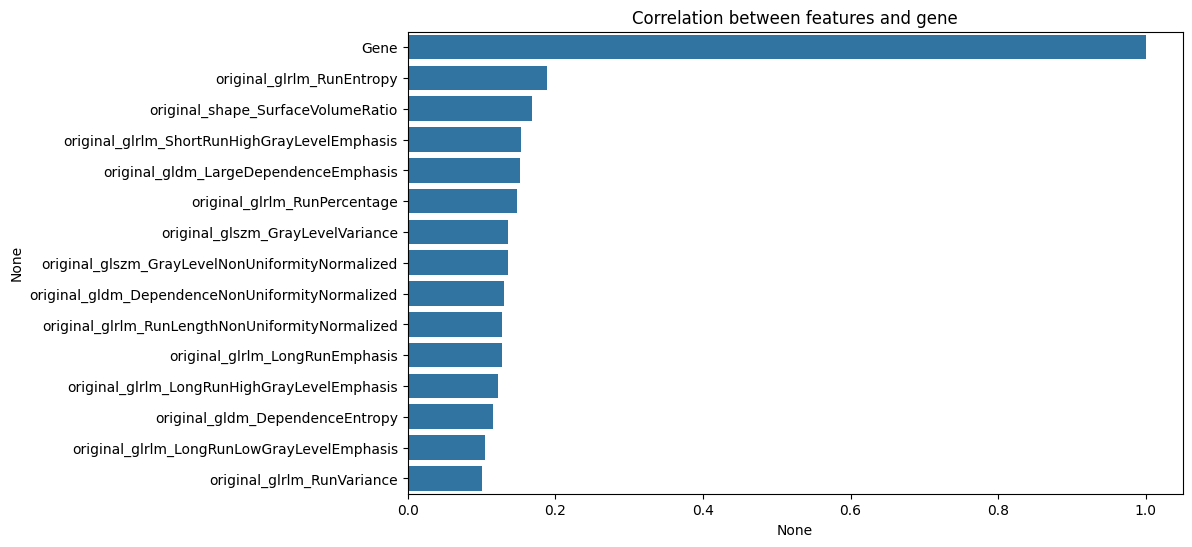

15


In [13]:
X = df.drop(['pCR (outcome)', 'RelapseFreeSurvival (outcome)'], axis=1)
y = df['Gene']

# Correlation between features and gene
corr = X.corrwith(y)
descending_corr = corr.abs().sort_values(ascending=False)

# keep only the features with score > 0,1
descending_corr = descending_corr[descending_corr > 0.1]

plt.figure(figsize=(10, 6))
sns.barplot(x=descending_corr, y=descending_corr.index)
plt.title('Correlation between features and gene')
plt.show()

keep_feat_names = list(descending_corr.index)
print(len(keep_feat_names))

## saved the selected features in a file
import json
with open('gene_clf_selected_features.json', 'w') as f:
  json.dump(keep_feat_names, f)

In [3]:
# train a model with the selected features
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

keep_df = X[keep_feat_names]
# keep_df = X[:]

## only train on data with gene
Xs = keep_df[keep_df['Gene'] != 999]

y = Xs['Gene']
Xs = Xs.drop('Gene', axis=1)

print(Xs.shape)
print(Xs.columns)

scaler = StandardScaler()
Xs = scaler.fit_transform(Xs)

X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, random_state=42)


(312, 14)
Index(['original_glrlm_RunEntropy', 'original_shape_SurfaceVolumeRatio',
       'original_glrlm_ShortRunHighGrayLevelEmphasis',
       'original_gldm_LargeDependenceEmphasis', 'original_glrlm_RunPercentage',
       'original_glszm_GrayLevelVariance',
       'original_glszm_GrayLevelNonUniformityNormalized',
       'original_gldm_DependenceNonUniformityNormalized',
       'original_glrlm_RunLengthNonUniformityNormalized',
       'original_glrlm_LongRunEmphasis',
       'original_glrlm_LongRunHighGrayLevelEmphasis',
       'original_gldm_DependenceEntropy',
       'original_glrlm_LongRunLowGrayLevelEmphasis',
       'original_glrlm_RunVariance'],
      dtype='object')


### Train model
Try LogisticRegression, SVM, and RandomForest

In [4]:
# try logistic reg
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

log_reg_grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, n_jobs=-1)
log_reg_grid.fit(X_train, y_train)

print(f'Best params: {log_reg_grid.best_params_}')
print(f'Best score: {log_reg_grid.best_score_}')

y_pred = log_reg_grid.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')


Best params: {'C': np.float64(0.23357214690901212), 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.6186122448979592
Accuracy: 0.6507936507936508


In [6]:
# try SVM
from sklearn.svm import SVC

param_grid = {
    'C': np.logspace(-4, 4, 20),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

svm_grid = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1)
svm_grid.fit(X_train, y_train)

print(f'Best params: {svm_grid.best_params_}')
print(f'Best score: {svm_grid.best_score_}')

y_pred = svm_grid.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')


Best params: {'C': np.float64(0.03359818286283781), 'kernel': 'poly'}
Best score: 0.6184489795918366
Accuracy: 0.6349206349206349


In [8]:
# try random forest with grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, 40, 50]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)

print(accuracy_score(y_test, y_pred))


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_es

### Result - SVM 
LogisticRegression with params: {'C': np.float64(0.23357214690901212), 'penalty': 'l1', 'solver': 'liblinear'} achieved ~65% accuracy - we will use this for Gene imputation

In [10]:
# save model
import pickle

log_reg_classifier = LogisticRegression(**log_reg_grid.best_params_)

# train on whole ds
log_reg_classifier.fit(Xs, y)

with open('log_reg_gene_classifier.pkl', 'wb') as f:
    pickle.dump(log_reg_classifier, f)
  